# Libraries

In [26]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import TFBertForSequenceClassification, TFBertTokenizer
#import torch
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from causalml.inference.meta import LRSRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.inference.meta import BaseXLearner

In [6]:
# Removing row and column limit for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data load

## Data file path

In [7]:
# Download dataset directly to Colab's storage
path = kagglehub.dataset_download("justinpakzad/vestiaire-fashion-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/atharvavyas/.cache/kagglehub/datasets/justinpakzad/vestiaire-fashion-dataset/versions/2


In [8]:
print(os.listdir(path))

['vestiaire.csv']


## Saving the dataframe

In [9]:
df = pd.read_csv(os.path.join(path, 'vestiaire.csv'))

## First 5 rows

In [10]:
df.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,sold,reserved,available,in_stock,should_be_gone,brand_id,brand_name,brand_url,product_material,product_color,price_usd,seller_price,seller_earning,seller_badge,has_cross_border_fees,buyers_fees,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate
0,43247626,Wool mini skirt,Wool mini skirt Miu Miu Grey size S Internatio...,Miu Miu – Pleated mini skirt Size: 36 (S) Wai...,Miu Miu Wool Skirts,Women,Women Clothing,Autumn / Winter,Never worn,34.0,True,False,True,False,False,117,Miu Miu,http://vestiairecollective.com/miu-miu/,Wool,Grey,272.92,223.65,216.94,Common,NaN,NaN,Tourcoing,25775970,vitalii25775970,NaN,Germany,3.0,14.0,0.0,13.0,0.0
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,161,Barbara Bui,http://vestiairecollective.com/barbara-bui/,Cotton,Navy,127.80,106.50,106.50,Common,True,21.30,Tourcoing,13698770,olivia13698770,NaN,Belgium,0.0,0.0,0.0,8.0,0.0
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2.0,False,False,True,False,False,391,Comme Des Garcons,http://vestiairecollective.com/comme-des-garcons/,Wool,White,1278.00,1065.00,926.55,Expert,True,213.00,Tourcoing,6042365,cecilia6042365,1-2 days,Spain,58.0,69.0,0.0,62.0,96.0
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0.0,False,False,True,False,False,2797,MSGM,http://vestiairecollective.com/msgm/,Polyester,Black,163.90,149.00,126.65,Expert,True,14.90,Brooklyn,13172949,gretchen13172949,1-2 days,United States,63.0,274.0,126346.0,131.0,96.0
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,11956,LVIR,http://vestiairecollective.com/lvir/,Vegan leather,Black,119.72,99.77,83.55,Common,True,19.95,Crawley,2578605,crunchykat,3-5 days,United Kingdom,19.0,14.0,102821.0,40.0,89.0


## Dataframe info

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900514 entries, 0 to 900513
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   product_id                  900514 non-null  int64  
 1   product_type                900514 non-null  object 
 2   product_name                900514 non-null  object 
 3   product_description         900507 non-null  object 
 4   product_keywords            899331 non-null  object 
 5   product_gender_target       900514 non-null  object 
 6   product_category            899331 non-null  object 
 7   product_season              900512 non-null  object 
 8   product_condition           900514 non-null  object 
 9   product_like_count          900514 non-null  float64
 10  sold                        900514 non-null  bool   
 11  reserved                    900514 non-null  bool   
 12  available                   900514 non-null  bool   
 13  in_stock      

# Data cleaning

## Missing data

In [12]:
# Percent of missing values in each column and count of missing values arranged by top 10 most missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage(%)': missing_percentage})
missing_info.sort_values(by='Percentage(%)', ascending=False)


,Missing Values,Percentage(%)
usually_ships_within,154791,17.189183
has_cross_border_fees,13736,1.525351
buyers_fees,13736,1.525351
product_keywords,1183,0.131369
product_category,1183,0.131369
seller_username,39,0.004331
product_description,7,0.000777
product_material,4,0.000444
product_season,2,0.000222
product_color,1,0.000111


Columns this analysis is interested in: **product_description**, **sold**, **price_usd**, **seller_price**. 

Drop missing values of **product_description** 

In [13]:
# Drop all missing values of product_description
df.dropna(subset=['product_description'], inplace=True)

## New column called price_diff

This column will find out how much the price difference is as a percentage of the original price of the product

In [14]:
df['price_diff_percent'] = ((df['price_usd']-df['seller_earning'])/df['price_usd'])*100

In [15]:
df.head()

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,sold,reserved,available,in_stock,should_be_gone,brand_id,brand_name,brand_url,product_material,product_color,price_usd,seller_price,seller_earning,seller_badge,has_cross_border_fees,buyers_fees,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate,price_diff_percent
0,43247626,Wool mini skirt,Wool mini skirt Miu Miu Grey size S Internatio...,Miu Miu – Pleated mini skirt Size: 36 (S) Wai...,Miu Miu Wool Skirts,Women,Women Clothing,Autumn / Winter,Never worn,34.0,True,False,True,False,False,117,Miu Miu,http://vestiairecollective.com/miu-miu/,Wool,Grey,272.92,223.65,216.94,Common,NaN,NaN,Tourcoing,25775970,vitalii25775970,NaN,Germany,3.0,14.0,0.0,13.0,0.0,20.511505
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,161,Barbara Bui,http://vestiairecollective.com/barbara-bui/,Cotton,Navy,127.80,106.50,106.50,Common,True,21.30,Tourcoing,13698770,olivia13698770,NaN,Belgium,0.0,0.0,0.0,8.0,0.0,16.666667
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2.0,False,False,True,False,False,391,Comme Des Garcons,http://vestiairecollective.com/comme-des-garcons/,Wool,White,1278.00,1065.00,926.55,Expert,True,213.00,Tourcoing,6042365,cecilia6042365,1-2 days,Spain,58.0,69.0,0.0,62.0,96.0,27.500000
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0.0,False,False,True,False,False,2797,MSGM,http://vestiairecollective.com/msgm/,Polyester,Black,163.90,149.00,126.65,Expert,True,14.90,Brooklyn,13172949,gretchen13172949,1-2 days,United States,63.0,274.0,126346.0,131.0,96.0,22.727273
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1.0,False,False,True,False,False,11956,LVIR,http://vestiairecollective.com/lvir/,Vegan leather,Black,119.72,99.77,83.55,Common,True,19.95,Crawley,2578605,crunchykat,3-5 days,United Kingdom,19.0,14.0,102821.0,40.0,89.0,30.212162


## Descriptive statistics for numerical columns

In [16]:
df.describe()

,product_id,product_like_count,brand_id,price_usd,seller_price,seller_earning,buyers_fees,seller_id,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate,price_diff_percent
count,9.005070e+05,900507.000000,900507.000000,900507.000000,900507.000000,900507.000000,886771.000000,9.005070e+05,900507.000000,900507.000000,9.005070e+05,9.005070e+05,900507.000000,900507.000000
mean,3.810022e+07,6.298300,2437.270803,386.864061,331.640751,290.437698,55.486339,1.382232e+07,664.959983,1497.669615,5.623196e+04,9.904691e+03,72.461618,29.868420
std,7.749142e+06,12.920106,3702.867265,1859.566252,1591.478879,1498.163329,290.261103,7.535594e+06,3552.758248,5460.187171,1.438161e+05,3.557500e+05,34.428758,10.918541
min,1.113630e+05,0.000000,2.000000,6.130000,5.110000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,-180.000000,0.000000
25%,3.811600e+07,1.000000,66.000000,83.070000,71.360000,58.580000,11.720000,7.977389e+06,6.000000,10.000000,0.000000e+00,1.700000e+01,68.000000,26.666139
50%,4.174208e+07,3.000000,341.000000,168.700000,143.780000,125.370000,23.970000,1.438324e+07,34.000000,52.000000,0.000000e+00,7.300000e+01,88.000000,27.526370
75%,4.267775e+07,7.000000,3266.000000,350.000000,298.200000,261.900000,50.480000,1.946237e+07,178.000000,373.000000,2.539400e+04,2.900000e+02,95.000000,32.137268
max,4.324884e+07,3154.000000,18237.000000,632610.000000,527175.000000,509229.750000,105435.000000,2.608177e+07,79738.000000,39628.000000,1.064736e+06,1.417912e+07,100.000000,100.000000


# EDA

## Checking the product description column for possible text analysis

In [17]:
def show_full_description(df):
    with pd.option_context('display.max_colwidth', None):
        print(df[['product_description']].head(15))

In [18]:
show_full_description(df)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          product_description
0                                                                                                                                                                                                                                                                                                                                                                                         

## Class profile of product target gender

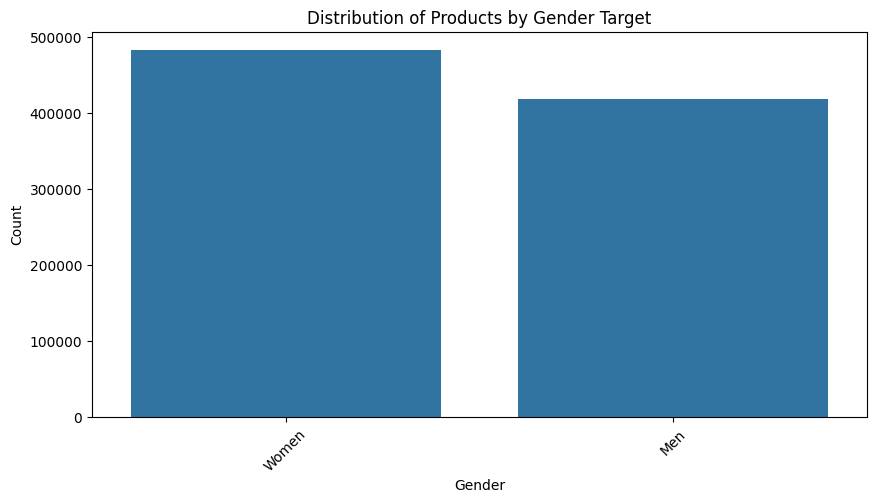

In [19]:
# Class imbalance visualised with plot for difference between male and female in gender column
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='product_gender_target')
plt.title('Distribution of Products by Gender Target')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Slightly imbalanced class, this is okay.

# Causal ML

### Hyopthesis :
Is overselling a product motivated by higher seller earnings?

## Sentiment analysis with VADER

In [22]:
# Initialize analyzer
try:
    sid = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()

In [23]:
def analyze_product_descriptions(df):
    """
    Analyze sentiment in product descriptions from a Vestiaire Collective dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing product data with 'product_description' column
    
    Returns:
    --------
    pandas.DataFrame
        The original DataFrame with additional sentiment analysis columns
    """
    # Check if product_description column exists
    if 'product_description' not in df.columns:
        raise ValueError("DataFrame must contain a 'product_description' column")
    
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Function to get sentiment scores for a text
    def get_sentiment_scores(text):
        if pd.isna(text) or not isinstance(text, str):
            return {'compound': None, 'pos': None, 'neg': None, 'neu': None}
        return sid.polarity_scores(text)
    
    # Apply sentiment analysis to the product descriptions
    sentiment_scores = result_df['product_description'].apply(get_sentiment_scores)
    
    # Extract each sentiment score component
    result_df['sentiment_compound'] = sentiment_scores.apply(lambda x: x.get('compound') if x else None)
    result_df['sentiment_positive'] = sentiment_scores.apply(lambda x: x.get('pos') if x else None)
    result_df['sentiment_negative'] = sentiment_scores.apply(lambda x: x.get('neg') if x else None)
    result_df['sentiment_neutral'] = sentiment_scores.apply(lambda x: x.get('neu') if x else None)
    
    # Categorize the sentiment
    result_df['sentiment_category'] = result_df['sentiment_compound'].apply(
        lambda score: 'Positive' if score and score >= 0.05 
                     else ('Negative' if score and score <= -0.05 else 'Neutral'))
    
    return result_df


In [24]:
def analyze_product_sentiment_summary(df):
    """
    Generate a summary of sentiment analysis results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing sentiment analysis results
    
    Returns:
    --------
    dict
        Dictionary containing summary statistics
    """
    if 'sentiment_category' not in df.columns:
        raise ValueError("DataFrame must contain sentiment analysis results")
    
    # Get the distribution of sentiment categories
    sentiment_counts = df['sentiment_category'].value_counts().to_dict()
    
    # Calculate percentages
    total = df['sentiment_category'].count()
    sentiment_percentages = {k: round(v/total*100, 2) for k, v in sentiment_counts.items()}
    
    # Get average sentiment scores
    avg_scores = {
        'avg_compound': df['sentiment_compound'].mean(),
        'avg_positive': df['sentiment_positive'].mean(),
        'avg_negative': df['sentiment_negative'].mean(),
        'avg_neutral': df['sentiment_neutral'].mean()
    }
    
    # Create summary
    summary = {
        'counts': sentiment_counts,
        'percentages': sentiment_percentages,
        'averages': avg_scores
    }
    
    return summary

In [25]:
# Analyze sentiment in product descriptions
df_with_sentiment = analyze_product_descriptions(df)

# Get summary statistics
summary = analyze_product_sentiment_summary(df_with_sentiment)

# Display results
print("\nSentiment Distribution:")
for category, percentage in summary['percentages'].items():
    print(f"  {category}: {percentage}%")

print("\nAverage Sentiment Scores:")
for score_type, value in summary['averages'].items():
    print(f"  {score_type}: {value:.4f}")

# See examples of products with different sentiment categories
print("\nPositive Description Examples:")
positive_examples = df_with_sentiment[df_with_sentiment['sentiment_category'] == 'Positive']
if not positive_examples.empty:
    for _, row in positive_examples.head(3).iterrows():
        print(f"  Product: {row['product_name']}")
        print(f"  Description: {row['product_description']}")
        print(f"  Sentiment Score: {row['sentiment_compound']:.4f}\n")

print("Negative Description Examples:")
negative_examples = df_with_sentiment[df_with_sentiment['sentiment_category'] == 'Negative']
if not negative_examples.empty:
    for _, row in negative_examples.head(3).iterrows():
        print(f"  Product: {row['product_name']}")
        print(f"  Description: {row['product_description']}")
        print(f"  Sentiment Score: {row['sentiment_compound']:.4f}\n")


Sentiment Distribution:
  Positive: 60.42%
  Neutral: 30.14%
  Negative: 9.43%

Average Sentiment Scores:
  avg_compound: 0.3082
  avg_positive: 0.1410
  avg_negative: 0.0313
  avg_neutral: 0.8276

Positive Description Examples:
  Product: Jacket Barbara Bui Navy size 42 FR in Cotton 
  Description: For selling nice women's suit Barbara Bui size fr 42
  Sentiment Score: 0.4215

  Product: Wool coat Comme Des Garcons White size S International in Wool 
  Description: Magnificent boiled wool coat. I bought it in the late 2000s. I have worn it on only 1 occasion. I have never received so many compliments on a piece as I did on that day. I washed it when I bought it. It is in magnificent condition, without any alteration. It is missing the composition label, which I usually remove as soon as I buy the garment. On this occasion, when removing it, the size S label was also removed. See measurements. Measurements, with the coat closed in a horizontal position: Shoulder-shoulder = 45 cm Armpi

## Causal analysis for:
1. Does the amount a seller earns from a product reflect their sentiment in product description?
2. Does the sentiment of a product description affect the whether a product is sold or not?

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from causalml.inference.meta import LRSRegressor, XGBTRegressor, MLPTRegressor
from causalml.metrics import get_cumgain
from causalml.inference.meta import BaseSRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Download VADER lexicon if needed
try:
    sid = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()
    
# Add sentiment scores if not already present
if 'sentiment_compound' not in df.columns:
    sentiment_scores = df['product_description'].apply(
        lambda text: sid.polarity_scores(text) if isinstance(text, str) and not pd.isna(text) 
        else {'compound': None, 'pos': None, 'neg': None, 'neu': None}
    )
    df['sentiment_compound'] = sentiment_scores.apply(lambda x: x.get('compound') if x else None)

# Prepare dataset for analysis 1: price_diff_percent -> sentiment_compound
df_analysis1 = df.dropna(subset=['price_diff_percent', 'sentiment_compound'])

# Define features for analysis 1
features1 = ['product_condition', 'brand_id', 'price_usd', 'seller_products_sold', 
           'seller_num_products_listed', 'seller_num_followers', 'seller_pass_rate']
X1 = df_analysis1[features1].copy()

# Convert categorical variables to dummy variables
for col in X1.select_dtypes(include=['object']).columns:
    X1 = pd.get_dummies(X1, columns=[col], drop_first=True)

# Fill missing values
X1 = X1.fillna(X1.median())

# Define treatment and outcome
treatment1 = (df_analysis1['price_diff_percent'] > df_analysis1['price_diff_percent'].median()).astype(int)
outcome1 = df_analysis1['sentiment_compound']

# Split data
X1_train, X1_test, treatment1_train, treatment1_test, outcome1_train, outcome1_test = train_test_split(
    X1, treatment1, outcome1, test_size=0.2, random_state=42
)

# Scale features
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

# Causal inference models for Analysis 1
models1 = {
    'S-Learner (LR)': LRSRegressor(),
    'S-Learner (XGB)': XGBTRegressor(),
    'S-Learner (MLP)': MLPTRegressor(random_state=42)
}

print("Analysis 1: Effect of price_diff_percent on sentiment_compound")
for name, model in models1.items():
    model.fit(X=X1_train_scaled, treatment=treatment1_train, y=outcome1_train)
    te_pred = model.predict(X=X1_test_scaled, treatment=treatment1_test)
    
    print(f"\n{name} Results:")
    print(f"Average Treatment Effect: {te_pred.mean():.4f}")
    print(f"95% CI: [{np.percentile(te_pred, 2.5):.4f}, {np.percentile(te_pred, 97.5):.4f}]")

# Prepare dataset for analysis 2: sentiment_compound -> sold
df_analysis2 = df.dropna(subset=['sentiment_compound', 'sold'])

# Define features for analysis 2
features2 = ['product_condition', 'brand_id', 'price_usd', 'price_diff_percent',
            'seller_products_sold', 'seller_num_products_listed', 'seller_num_followers', 
            'seller_pass_rate']
X2 = df_analysis2[features2].copy()

# Convert categorical variables to dummy variables
for col in X2.select_dtypes(include=['object']).columns:
    X2 = pd.get_dummies(X2, columns=[col], drop_first=True)

# Fill missing values
X2 = X2.fillna(X2.median())

# Define treatment and outcome
treatment2 = (df_analysis2['sentiment_compound'] > df_analysis2['sentiment_compound'].median()).astype(int)
outcome2 = df_analysis2['sold'].astype(int)

# Split data
X2_train, X2_test, treatment2_train, treatment2_test, outcome2_train, outcome2_test = train_test_split(
    X2, treatment2, outcome2, test_size=0.2, random_state=42
)

# Scale features
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

# Causal inference models for Analysis 2
models2 = {
    'S-Learner (LR)': LRSRegressor(),
    'S-Learner (XGB)': XGBTRegressor(),
    'S-Learner (MLP)': MLPTRegressor(random_state=42)
}

print("\nAnalysis 2: Effect of sentiment_compound on sold status")
for name, model in models2.items():
    model.fit(X=X2_train_scaled, treatment=treatment2_train, y=outcome2_train)
    te_pred = model.predict(X=X2_test_scaled, treatment=treatment2_test)
    
    print(f"\n{name} Results:")
    print(f"Average Treatment Effect: {te_pred.mean():.4f}")
    print(f"95% CI: [{np.percentile(te_pred, 2.5):.4f}, {np.percentile(te_pred, 97.5):.4f}]")

# CATE for different subgroups
print("\nConditional Average Treatment Effects (CATE) for Analysis 2:")
best_model = models2['S-Learner (XGB)']
cate_pred = best_model.predict(X=X2_test_scaled)

# Extract price data before train-test split and scaling
# Store original price values for later use in categorization
original_prices = X2['price_usd'].values
test_indices = np.arange(len(X2))[len(X2_train):]  # Get indices for test set
test_prices = original_prices[test_indices]  # Get prices for test set only

# Create categories
price_categories = pd.cut(test_prices, bins=3, labels=['Low', 'Medium', 'High'])

# Calculate CATE by price segment
for category in ['Low', 'Medium', 'High']:
    mask = price_categories == category
    if any(mask):
        print(f"CATE for {category} price segment: {cate_pred[mask].mean():.4f}")
    else:
        print(f"No items found in {category} price segment")

Analysis 1: Effect of price_diff_percent on sentiment_compound

S-Learner (LR) Results:
Average Treatment Effect: -0.0226
95% CI: [-0.0226, -0.0226]

S-Learner (XGB) Results:
Average Treatment Effect: -0.0310
95% CI: [-0.4206, 0.3099]

S-Learner (MLP) Results:
Average Treatment Effect: -0.0210
95% CI: [-0.2370, 0.2001]

Analysis 2: Effect of sentiment_compound on sold status

S-Learner (LR) Results:
Average Treatment Effect: -0.0004
95% CI: [-0.0004, -0.0004]

S-Learner (XGB) Results:
Average Treatment Effect: 0.0014
95% CI: [-0.0331, 0.0368]

S-Learner (MLP) Results:
Average Treatment Effect: 0.0077
95% CI: [-0.0077, 0.0231]

Conditional Average Treatment Effects (CATE) for Analysis 2:
CATE for Low price segment: 0.0014
CATE for Medium price segment: 0.0026
CATE for High price segment: -0.0010
